# desc-wfmon/montab.ipynb: Monitor table viewing example

We use the classes in desc-wfmon to examine one of the monitoring tables from DESC gen3 parsl jobs.

Copy this file to the run directory or modiufy variable *dir* below.

First setup to use the local install area and then import the the system (sysmon) and process (wfmon) explorers. 

See desc-wfmon/install.ipynb to install that package in the local directory and create the setup on the first line. 

In [1]:
!pwd
%run install/setup.py
import sys
print(f"Python version is {sys.version}")
print(f"Python search path starts with {sys.path[0]}:{sys.path[1]}:{sys.path[2]}")
import pandas
import matplotlib.pyplot as plt
import matplotlib.colors as pltcol
import desc.wfmon
import desc.sysmon
for pkg in [desc.wfmon, desc.sysmon]:
    print(f"{pkg} version is {pkg.__version__}")

/global/u2/d/dladams/desc/rundirs/test20
Python version is 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]
Python search path starts with ./install/noconda:/global/u2/d/dladams/desc/rundirs/test20:
<module 'desc.wfmon' from '/global/u2/d/dladams/desc/rundirs/test20/./install/noconda/desc/wfmon/__init__.py'> version is 0.0.15
<module 'desc.sysmon' from '/global/u2/d/dladams/desc/rundirs/test20/./install/noconda/desc/sysmon/__init__.py'> version is 0.0.15


## Configuration
Define some useful constants and specify the location of the monitoring data files. Set dir to point to your area.

In [4]:
mb = 2**20
gb = 2**30
bunit = gb
bunit_sys = bunit/gb
sbunit = 'GB'

dir = f"./"
dirProc = dir + 'runinfo/'
line = '-----------------------------------------------------------'

## Fetch system-level monitoring data

System level monitoring data is collected using *desc.sysmon*. The data is in csv format and is read here with *pandas*.

The column names follow from those of the corresponding *psutil* variables.

We fetch the number of CPUs and total memory and check both are consistent for all samples.

In [5]:
sym = pandas.read_csv(dir + 'sysmon.csv')
print(f"System monitor sample count: {len(sym)}")
print(f"System monitor columns:")
for cnam in sym.columns:
    print(f"  {cnam}")

assert(len(sym.cpu_count.unique()) == 1)
ncpu = sym.cpu_count[0]
print(f"CPU count is {ncpu:.0f}")

assert(len(sym.mem_total.unique()) == 1)
maxmem = sym.mem_total[0]/bunit_sys
print(f"Total memory is {maxmem:.1f} {sbunit}")


System monitor sample count: 718
System monitor columns:
  time
  cpu_count
  cpu_percent
  cpu_user
  cpu_system
  cpu_idle
  cpu_iowait
  cpu_time
  mem_total
  mem_available
  mem_swapfree
  dio_readsize
  dio_writesize
  nio_readsize
  nio_writesize
CPU count is 64
Total memory is 125.8 GB


## Fetch the process-level monitoring data

The process monitoring data is read from the mysql DB produced by parsl. Of particular interest is the task table where metrics are sampled at regular intervals seprately for each job.

We "fix" that data to make it more amenable for analysis. Among many other modifications, fixing converts time strings to integers and add a procsum (process summary) table which sums the contributions from all jobs. Although the sampling interval is the same for all jobs, they have different offsets and so there is some ambiguity in this summing.

For disk and network I/O, integrated values are recorded but the differential values (the amount read or written each sampling interval) are of interest here. A separate call is made to build a procsum table that includes these differential values. This is not done automatically because it can be slow.

In [6]:
dbr = desc.wfmon.MonDbReader(dirProc + 'monitoring.db', dodelta=True)
print(line)
dbr.tables(2)

-----------------------------------------------------------
DB ./runinfo/monitoring.db has 9 tables
*******************************************************
Table workflow has 1 rows and 9 columns
Column names:
     int64   run_idx
     int64   wf_idx
   float64   time_began
    object   time_completed
    object   host
    object   user
    object   rundir
     int64   tasks_failed_count
     int64   tasks_completed_count
*******************************************************
Table task has 2159 rows and 15 columns
Column names:
     int64   task_id
     int64   run_idx
    object   task_depends
     int64   task_idx
    object   task_memoize
    object   task_hashsum
    object   task_inputs
    object   task_outputs
    object   task_stdin
    object   task_stdout
    object   task_stderr
   float64   task_time_invoked
   float64   task_time_returned
     int64   task_fail_count
   float64   task_fail_cost
*******************************************************
Table try has 2159 ro

## procsum
Look at the procsum table

In [7]:
psm = dbr.table("procsumDelta")
print(pandas.get_option('display.width'))
pandas.set_option('display.width', 160)
pandas.set_option('display.max_columns', 20)
#print(psm)

80


In [8]:
taskid=255
olddf = dbr.table('resource').query(f"task_id=={taskid}")[['timestamp', 'psutil_process_time_user']].sort_values(by=['timestamp'])
print(olddf.diff())
#print(dbr.table('resource').query('task_id==255')['timestamp'].sort_values())

       timestamp  psutil_process_time_user
39365        NaN                       NaN
39391   3.000142                      0.30
39444   2.918900                      2.65
39483   3.056829                      2.81
39534   2.956895                      2.47
39586   3.057568                      2.03
39611   2.972936                      2.85
39656   2.964260                      2.84
39704   3.061438                      2.87
39752   3.021259                      3.21
39819   2.976374                      3.11
39865   2.997954                      3.14
39883   3.017583                      3.20
39961   3.000769                      3.18
40006   2.938535                      3.03
40064   3.289375                      3.63
40119   2.772324                      2.95
40173   2.995155                      2.91
40209   3.001769                      3.00
40255   3.001591                      2.89
40300   2.937762                      3.03
40358   3.011070                      3.14
40405   3.0

In [9]:
taskid = 255
dt = 1
toff = 0
dtoff = 0.1
maxdiff = 0
while len(olddf) > 2:
        maxdif = max(olddf.timestamp.add(toff).mod(dt).diff()[2:].abs())
        print(toff, maxdif)
        if maxdif < dt/2.: break
        if toff > dt/2 + 1:
            print(f"""WARNING: Unable to find offset for run task {taskid}. Using 0.0.""")
            toff = 0.0
            break
        toff = toff + dtoff
print(f"toff = {toff}, maxdif = {maxdif}")

0 0.28937506675720215
toff = 0, maxdif = 0.28937506675720215


In [8]:
print(dbr.taskproc(0, 255, False))

      timestamp  run_idx  task_idx  task_id  try_id  toff  procsum_time_clock  nsam  isam  proc_pid proc_status  proc_memory_percent  proc_memory_resident  \
0   3071.294898        0         3      255       0   0.0            2.785963    20     0      5018    sleeping             0.335379           452964352.0   
1   3072.283711        0         3      255       0   0.0            3.774776    20     1      5018    sleeping             0.352298           475869184.0   
2   3073.226626        0         3      255       0   0.0            4.717691    20     2      5018    sleeping             0.366949           495603712.0   
3   3074.239441        0         3      255       0   0.0            5.730506    20     3      5018    sleeping             0.377670           510083072.0   
4   3075.216097        0         3      255       0   0.0            6.707162    20     4      5018    sleeping             0.397907           537415680.0   
5   3076.194246        0         3      255       0 

In [14]:
print(dbr.taskproc(0,255)['timestamp'])

0     3071.294898
1     3072.283711
2     3073.226626
3     3074.239441
4     3075.216097
5     3076.194246
6     3077.208077
7     3078.250139
8     3079.220987
9     3080.249559
10    3081.236621
11    3082.244959
12    3083.267548
13    3084.274495
14    3085.265289
15    3086.603557
16    3087.583862
17    3088.933646
18    3090.263611
19    3091.315372
Name: timestamp, dtype: float64


In [10]:
print(dbr.taskproc(0,33))

     timestamp  run_idx  task_idx  task_id  try_id  toff  procdel_time_clock  nsam  isam  proc_pid proc_status  proc_memory_percent  proc_memory_resident  \
0   376.445388        0         3       33       0   0.0            0.219018    27     0     55391    sleeping             0.334745           452108288.0   
1   377.401268        0         3       33       0   0.0            0.955880    27     1     55391    sleeping             0.344301           465014784.0   
2   378.401545        0         3       33       0   0.0            1.000277    27     2     55391    sleeping             0.364475           492261376.0   
3   379.388082        0         3       33       0   0.0            0.986537    27     3     55391    sleeping             0.367495           496340992.0   
4   380.376127        0         3       33       0   0.0            0.988045    27     4     55391    sleeping             0.372044           502484992.0   
5   381.377533        0         3       33       0   0.0  

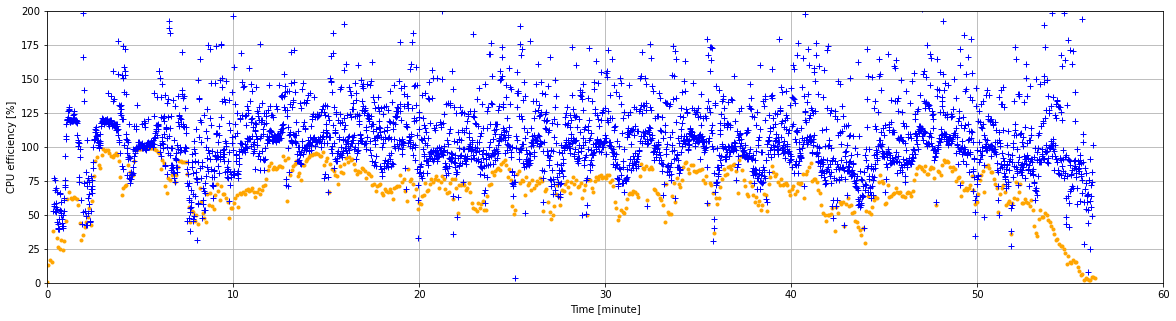

In [11]:
pdx = 20
pdy = 5
minute = 60
hour = 3600
day = 24*hour
tunit = minute
stunit = 'minute'
t0sec = dbr.t0
delt = dbr.monitoring_interval
deltsys = (max(sym.time) - min(sym.time))/float(len(sym) - 1)
tmin = 0
tmax = 60

psm = dbr.table('procsum')
psm['tfix'] = psm.timestamp/tunit
sym['tfix'] = (sym.time - t0sec)/tunit
plt.figure(figsize=(pdx, pdy))
plt.plot(sym.tfix, sym.cpu_percent, '.', color='orange')
plt.plot(psm.tfix, 100*(psm.procsum_time_user+psm.procsum_time_system)/psm.procsum_time_clock, 'b+')
plt.xlabel(f"Time [{stunit}]")
plt.ylabel('CPU efficiency [%]')
plt.grid(True)
junk = plt.axis([tmin, tmax, 0, 200])

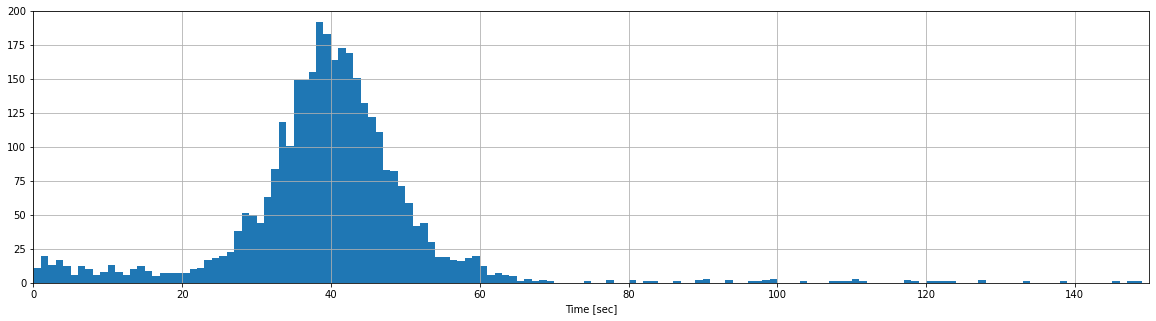

In [12]:
plt.figure(figsize=(pdx, pdy))
plt.hist(bins=150, range=(0,150), x=psm.procsum_time_clock)
plt.xlabel(f"Time [sec]")
plt.grid(True)
junk = plt.axis([tmin, 150, 0, 200])

In [13]:
print(f"Maximum number of tries is {dbr.table('try')['try_id'].max()}")

Maximum number of tries is 0
